In [1]:
# https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

# 🧠 Exploratory Data Analysis (EDA) Objectives for Stroke Prediction Dataset

This analysis aims to explore and understand patterns, trends, and risk factors associated with stroke, using both clinical relevance and data science best practices.

## 🔬 Health & Clinical Questions
1. **Who is at the highest risk of stroke?**
   - Age, gender, hypertension, heart disease, smoking status
2. **Does BMI influence stroke likelihood?**
3. **How is average glucose level related to stroke?**
4. **Are there rural vs urban disparities in stroke prevalence?**
5. **What types of work are associated with higher stroke risk?**
6. **Does marital status affect stroke occurrence?**

## 📊 Data Science Questions
7. **Are there missing values or anomalies?**
8. **Are any features highly correlated?**
9. **Are stroke cases imbalanced (class imbalance)?**
10. **Are there outliers in BMI or glucose levels?**
11. **How are numerical features distributed (e.g., skewed)?**
12. **Which features might be most predictive (feature importance)?**


In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve, average_precision_score
)

from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import calibration_curve


# Saving The Best Model and Scaler
import os
import pickle


%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
df.shape

(5110, 12)

In [4]:
df = df.drop('id', axis=1)

In [5]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [6]:
df = df.rename(columns=str.lower)

### Exploratory Data Analysis

In [7]:
df.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

The 'Other' gender is negligible so we can do without it

In [8]:
df = df[df['gender'] != 'Other']
df.gender.value_counts()

Female    2994
Male      2115
Name: gender, dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   object 
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   ever_married       5109 non-null   object 
 5   work_type          5109 non-null   object 
 6   residence_type     5109 non-null   object 
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                4908 non-null   float64
 9   smoking_status     5109 non-null   object 
 10  stroke             5109 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.0+ KB


In [10]:
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

gender: 2 unique values
age: 104 unique values
hypertension: 2 unique values
heart_disease: 2 unique values
ever_married: 2 unique values
work_type: 5 unique values
residence_type: 2 unique values
avg_glucose_level: 3978 unique values
bmi: 418 unique values
smoking_status: 4 unique values
stroke: 2 unique values


In [11]:
print(f"Duplicate rows: {df.duplicated().sum()}")

# No duplicate rows was observed

Duplicate rows: 0


In [12]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

noticed there is missing value in bmi

In [13]:
# Descriptive statistics for numerical columns
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5109.000000,5109.000000,5109.000000,5109.000000,4908.00000,5109.000000
mean,43.229986,0.097475,0.054022,106.140399,28.89456,0.048738
std,22.613575,0.296633,0.226084,45.285004,7.85432,0.215340
min,0.080000,0.000000,0.000000,55.120000,10.30000,0.000000
25%,25.000000,0.000000,0.000000,77.240000,23.50000,0.000000
50%,45.000000,0.000000,0.000000,91.880000,28.10000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.10000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.60000,1.000000


In [14]:
# Handling missing values in bmi with imputation
"""BMI will be filled with median because the distribution is skewed to the right and has outliers"""
df['bmi'].fillna(df['bmi'].median(), inplace=True)

In [15]:
# checking to confirm if missing value have been completely imputed
df.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

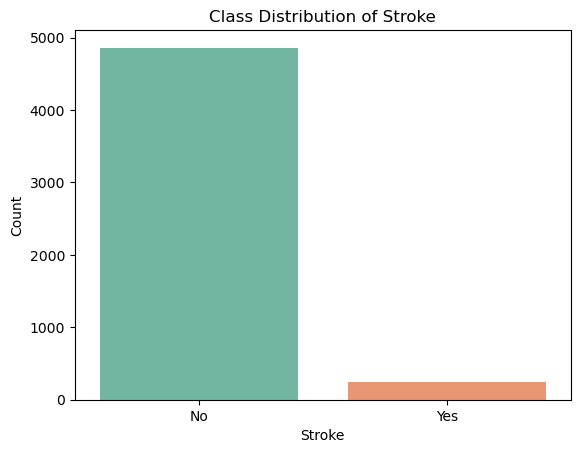

0    95.126248
1     4.873752
Name: stroke, dtype: float64


In [16]:
# Distribution of the Target variable

sns.countplot(x='stroke', data=df, palette='Set2')
plt.title('Class Distribution of Stroke')
plt.xlabel('Stroke')
plt.ylabel('Count')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

print(df['stroke'].value_counts(normalize=True) * 100)

From the countplot it could be clearly observed that the Target variable distribution is greatly imbalance 

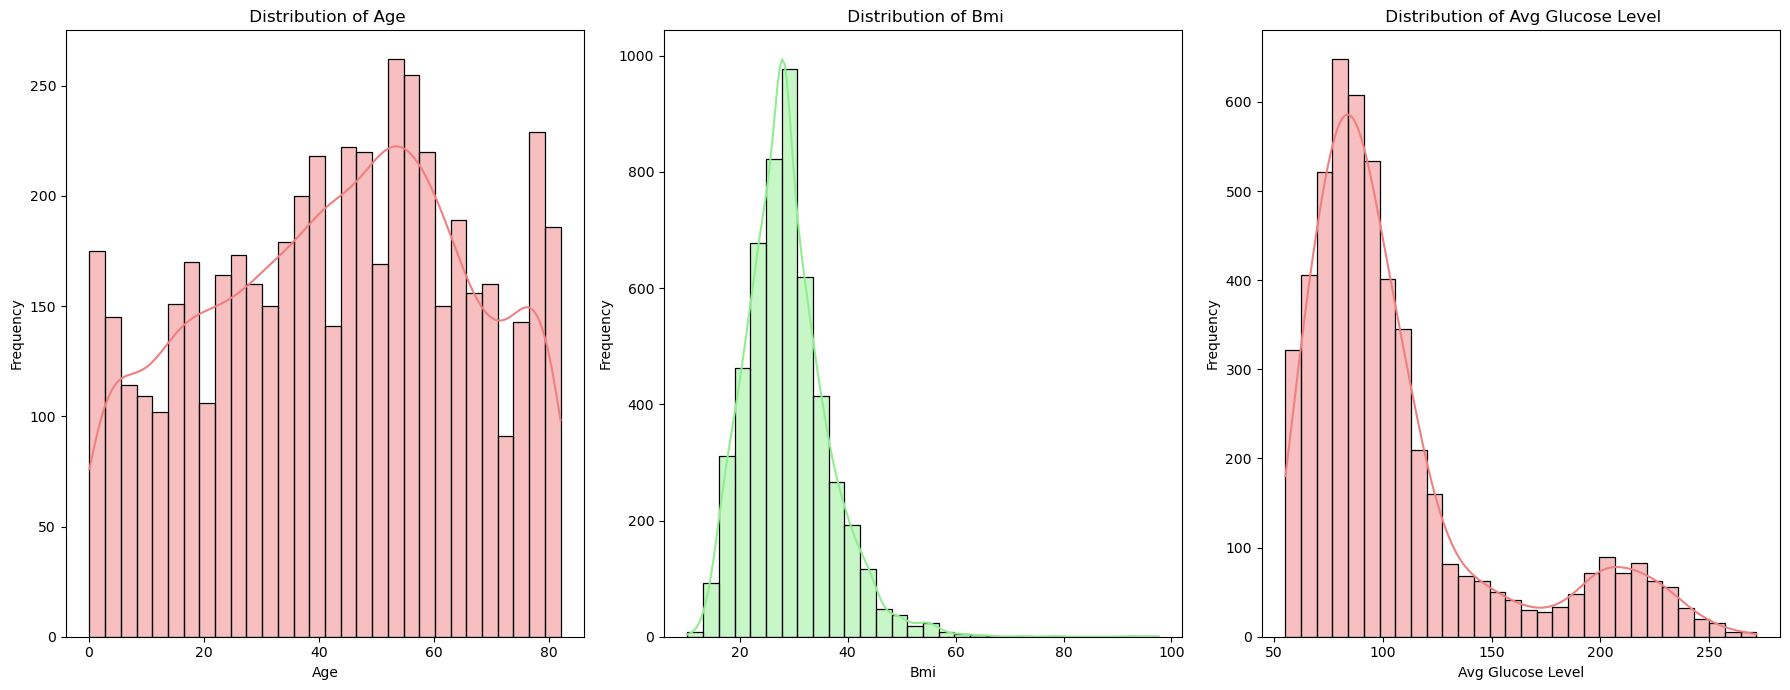

In [17]:
# Distribution of the continous numerical features

plt.figure(figsize=(18, 7))
cols = ['age', 'bmi', 'avg_glucose_level']
colors = ['lightcoral', 'lightgreen', 'lightcoral']

for i, col in enumerate(cols):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[col], kde=True, bins=30, color=colors[i])
    plt.title(f' Distribution of {col.replace("_", " ").title()}')
    plt.xlabel(col.replace("_", " ").title())
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

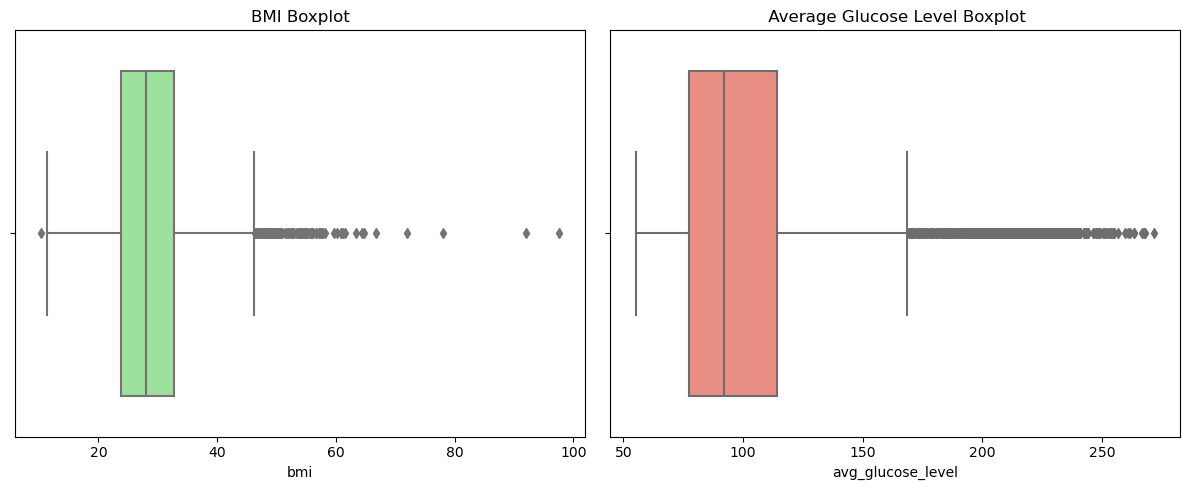

In [18]:
# Boxplot showing distribution of BMI and Average Glucose Level

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x='bmi', data=df, color='lightgreen')
plt.title('BMI Boxplot')

plt.subplot(1, 2, 2)
sns.boxplot(x='avg_glucose_level', data=df, color='salmon')
plt.title(' Average Glucose Level Boxplot')

plt.tight_layout()
plt.show()

From both boxplot above, it could be observe that they are multiple outliers in both BMI and Average Glucose Level.

**BMI**:
Median falls around 28.
Several **high outliers** beyond 40, with extreme values up to \~97.
Right-skewed distribution.

**Avg Glucose Level**:
Median is around 100.
outliers above \~150, extending beyond 250.
Also Right-skewed.

Both features contain **numerical outliers** and **skewed distributions**. This suggests the need for scaling or transformation, and possibly outlier handling before modeling.

In [19]:
# Detecting the exact number of outliers
features_to_check = ['avg_glucose_level', 'bmi']


def detect_outliers_IQR(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

for col in features_to_check:
    outliers = detect_outliers_IQR(df, col)
    print(f"{col}: {len(outliers)} outliers")


avg_glucose_level: 627 outliers
bmi: 126 outliers


In [20]:
outliers.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,44.089206,0.166667,0.007937,122.641905,52.974603,0.023810
std,14.094372,0.374166,0.089087,58.484164,8.373290,0.153064
min,1.240000,0.000000,0.000000,56.630000,10.300000,0.000000
25%,34.000000,0.000000,0.000000,79.420000,48.800000,0.000000
50%,45.000000,0.000000,0.000000,98.170000,51.600000,0.000000
75%,53.000000,0.000000,0.000000,184.835000,55.175000,0.000000
max,82.000000,1.000000,1.000000,253.160000,97.600000,1.000000


There is no need to winsorize the bmi and avg_glucose_level as there is possibility the extreme values were accurately measured, but the features will be scaled before modelling.

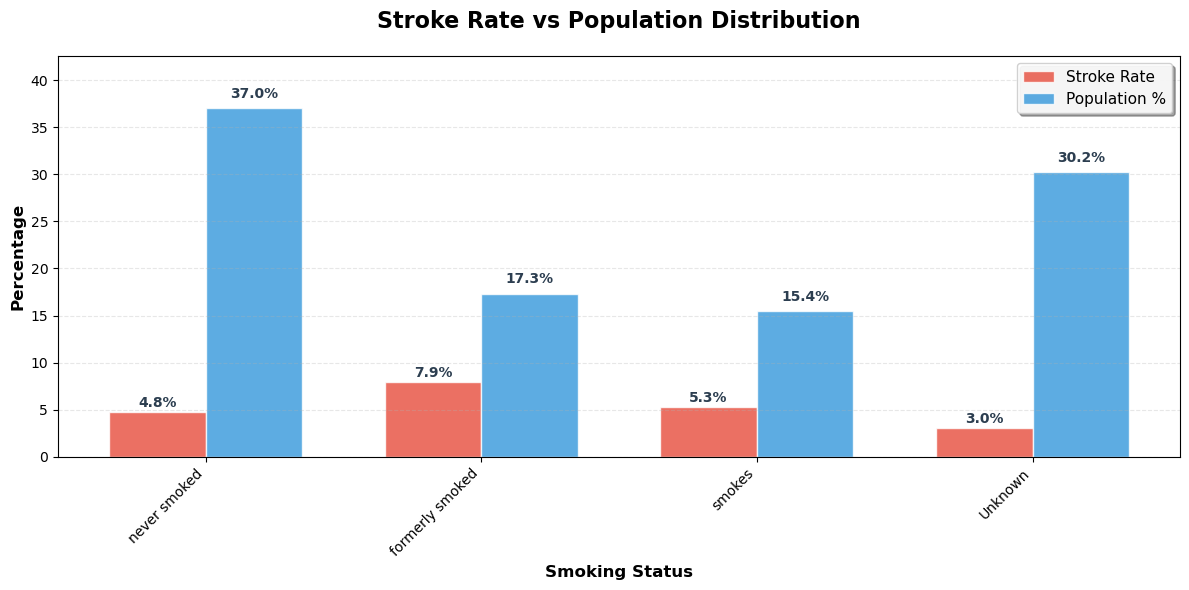

In [21]:
#  Stroke Rate vs smoking status

stroke_rates = df.groupby('smoking_status')['stroke'].mean().reset_index()
stroke_rates['stroke_percentage'] = stroke_rates['stroke'] * 100

# Creating smoking distribution dataframe
smoking_distribution = df['smoking_status'].value_counts(normalize=True).reset_index()
smoking_distribution.columns = ['smoking_status', 'proportion']
smoking_distribution['percentage'] = smoking_distribution['proportion'] * 100

# Ensuring same order for both datasets to align bars correctly
order = ['never smoked', 'formerly smoked', 'smokes', 'Unknown']
stroke_rates = stroke_rates.set_index('smoking_status').reindex(order).reset_index()
smoking_distribution = smoking_distribution.set_index('smoking_status').reindex(order).reset_index()

# Create the chart with better styling
plt.figure(figsize=(12, 6))
x = range(len(stroke_rates))
width = 0.35

# Use better colors - contrasting but professional
stroke_bars = plt.bar([i - width/2 for i in x], stroke_rates['stroke_percentage'], width, 
                     label='Stroke Rate', color='#e74c3c', alpha=0.8, edgecolor='white', linewidth=1)

population_bars = plt.bar([i + width/2 for i in x], smoking_distribution['percentage'], width, 
                         label='Population %', color='#3498db', alpha=0.8, edgecolor='white', linewidth=1)

# Adding aligned labels for stroke rates and distribution
for i, v in enumerate(stroke_rates['stroke_percentage']):
    plt.text(i - width/2, v + 0.2, f'{v:.1f}%', ha='center', va='bottom', 
             fontweight='bold', fontsize=10, color='#2c3e50')

for i, v in enumerate(smoking_distribution['percentage']):
    plt.text(i + width/2, v + 0.8, f'{v:.1f}%', ha='center', va='bottom', 
             fontweight='bold', fontsize=10, color='#2c3e50')

# Styling plot
plt.title('Stroke Rate vs Population Distribution', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Smoking Status', fontsize=12, fontweight='bold')
plt.ylabel('Percentage', fontsize=12, fontweight='bold')
plt.xticks(x, stroke_rates['smoking_status'], rotation=45, ha='right')

plt.legend(loc='upper right', frameon=True, fancybox=True, shadow=True, 
           fontsize=11, framealpha=0.9)

plt.grid(axis='y', alpha=0.3, linestyle='--') # Add grid for better readability


# Set y-axis to start from 0 for better comparison
plt.ylim(0, max(max(stroke_rates['stroke_percentage']), max(smoking_distribution['percentage'])) * 1.15)

plt.tight_layout()

plt.savefig("smoking status.png")
plt.show()

### Interpretation: Stroke Rate vs Population Distribution by Smoking Status

* **Formerly smoked** group has the **highest stroke rate (7.9%)**, despite being only **17.3%** of the population.
* **Current smokers (5.3%)** and **never smoked (4.8%)** have similar stroke rates, though **never smokers** represent the **largest group (37%)**.
* The **Unknown** group has the **lowest stroke rate (3%)**, but a **large population share (30.2%)** — may reflect data quality issues or unreported habits.

**Insight**: Stroke risk appears **highest among ex-smokers**, possibly due to cumulative smoking damage. This suggests that **past smoking history** is still a strong risk factor, and underscores the need for **early cessation**.


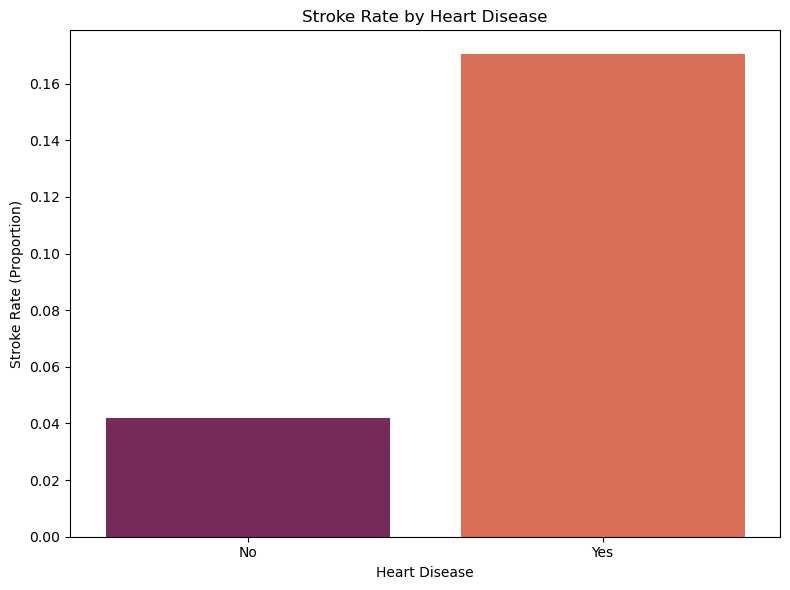

In [22]:
# Calculate stroke rate by heart_disease
stroke_rate_heart = df.groupby('heart_disease')['stroke'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='heart_disease', y='stroke', data=stroke_rate_heart, palette='rocket')
plt.title('Stroke Rate by Heart Disease')
plt.xlabel('Heart Disease')
plt.xticks([0, 1], ['No', 'Yes'])
plt.ylabel('Stroke Rate (Proportion)')

plt.tight_layout()
plt.show()

Barplot showing **Stroke Rate by Heart Disease**

* People **with heart disease** have a **significantly higher stroke rate** (\~17%) compared to those **without heart disease** (\~4%).

---

### Health & Data Science Relevant Questions This EDA Helps Answer:

1. **Does having heart disease increase the likelihood of stroke?**
   → **Yes**, the bar chart suggests a strong association between heart disease and stroke incidence.

2. **What is the magnitude of difference in stroke occurrence between those with and without heart disease?**
   → Roughly **4x higher** risk among those with heart disease.

3. **Can heart disease be considered a potential risk factor in stroke prediction models?**
   → Yes, the strong correlation suggests that **heart disease should be a key feature** in any predictive modeling (e.g., logistic regression, decision trees).

4. **Are there preventable cardiovascular conditions that can help reduce stroke burden?**
   → This analysis underscores the need to **manage heart disease proactively** to reduce stroke risk.

5. **How do comorbidities influence stroke outcomes?**
   → Heart disease, as a comorbidity, significantly influences stroke risk.

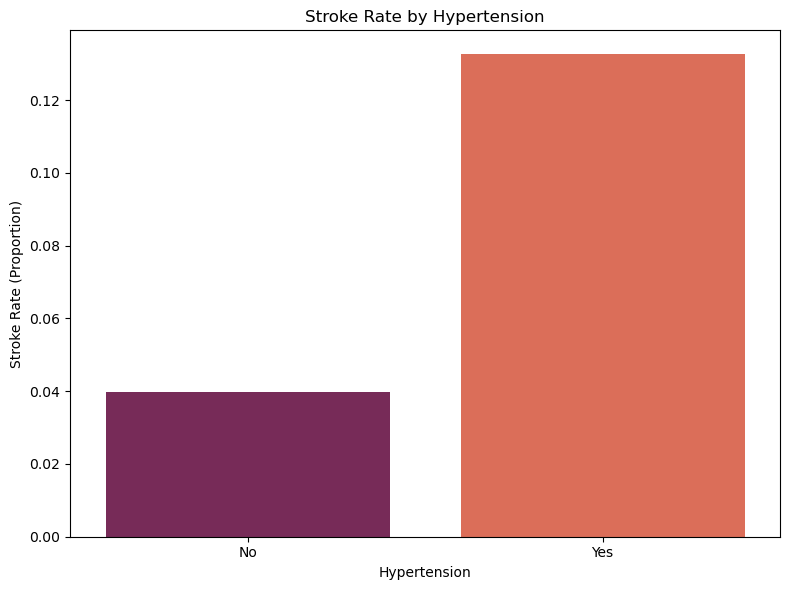

0    4611
1     498
Name: hypertension, dtype: int64

In [23]:
# Calculate stroke rate by hypertension
stroke_rate_hypertension = df.groupby('hypertension')['stroke'].mean().reset_index()

# Create the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x='hypertension', y='stroke', data=stroke_rate_hypertension, palette='rocket')
plt.title('Stroke Rate by Hypertension')
plt.xlabel('Hypertension')
plt.xticks([0, 1], ['No', 'Yes'])
plt.ylabel('Stroke Rate (Proportion)')


plt.tight_layout()
plt.show()

df.hypertension.value_counts()

**Hypertension dramatically increases stroke risk by over 3x:**

- **No hypertension**: ~4% stroke rate
- **With hypertension**: ~13% stroke rate

This represents a **225% increase** in stroke risk for people with hypertension. This finding confirms hypertension as one of the most significant modifiable risk factors for stroke, making blood pressure control critical for stroke prevention.

The magnitude of this difference underscores why hypertension management is a cornerstone of cardiovascular health and stroke prevention strategies.

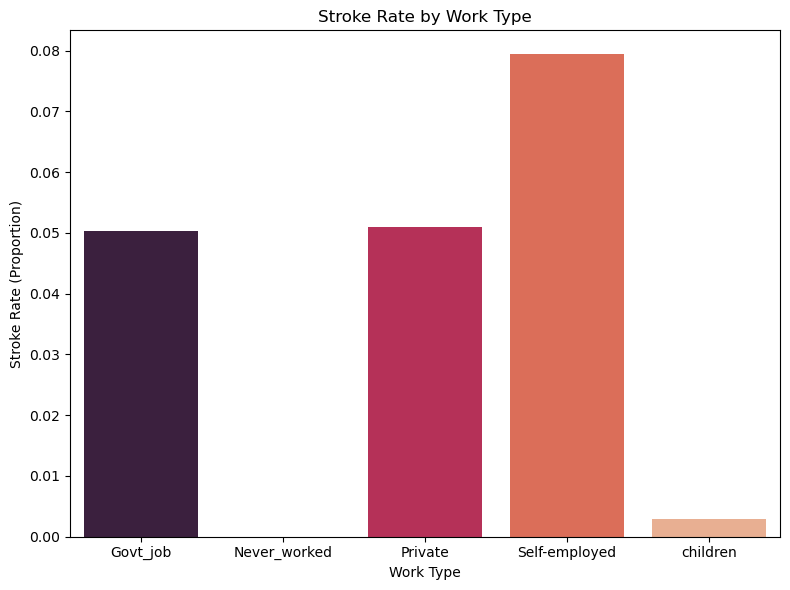

Private          57.232335
Self-employed    16.030534
children         13.446858
Govt_job         12.859659
Never_worked      0.430613
Name: work_type, dtype: float64

In [24]:
# Calculate stroke rate by residence type
stroke_rate = df.groupby('work_type')['stroke'].mean().reset_index()

# Create the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x='work_type', y='stroke', data=stroke_rate, palette='rocket')
plt.title('Stroke Rate by Work Type')
plt.xlabel('Work Type')
plt.ylabel('Stroke Rate (Proportion)')


plt.tight_layout()
plt.show()

df.work_type.value_counts(normalize=True) * 100

## Key Insights:

**Self-employed workers have the highest stroke risk at ~7.9%** - significantly higher than all other work types.

**Stroke rates by work type:**
- **Self-employed**: ~7.9% (highest risk)
- **Government job**: ~5.0%
- **Private sector**: ~5.1%
- **Never worked**: ~0% (virtually no strokes)
- **Children**: ~0.3% (lowest, as expected)

## Possible Explanations:

**Self-employed higher risk could be due to:**
- **Higher stress levels** from business ownership responsibilities
- **Irregular work schedules** and work-life balance issues
- **Less access to employer health benefits** and regular healthcare
- **Potentially older age group** (more established in careers)
- **Lifestyle factors** related to entrepreneurial demands

**Never worked showing near-zero rate** suggests this group may be predominantly younger/healthier individuals or those unable to work due to other factors.

**Takeaway:** Self-employment appears to be associated with significantly elevated stroke risk, potentially highlighting the importance of stress management and healthcare access for entrepreneurs and business owners.

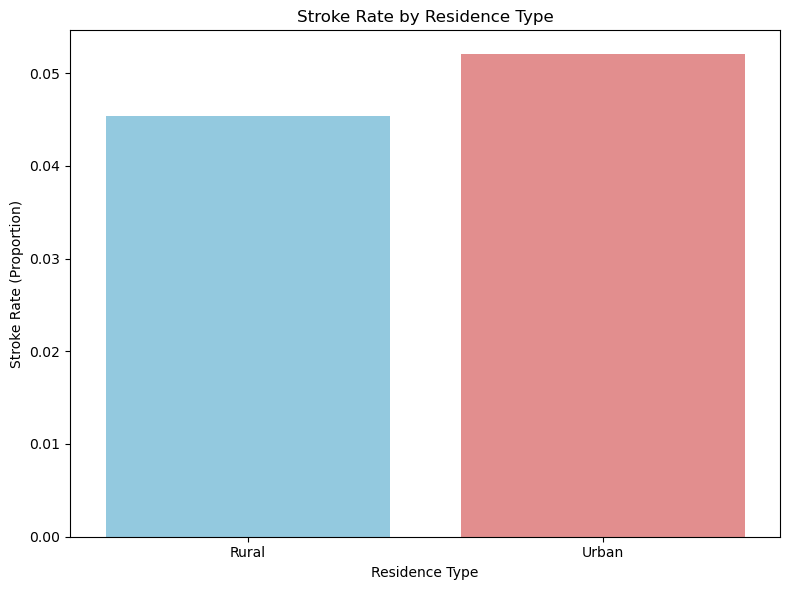

In [25]:
# Calculate stroke rate by residence type
stroke_rate = df.groupby('residence_type')['stroke'].mean().reset_index()

# Create the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x='residence_type', y='stroke', data=stroke_rate, palette=['skyblue', 'lightcoral'])
plt.title('Stroke Rate by Residence Type')
plt.xlabel('Residence Type')
plt.ylabel('Stroke Rate (Proportion)')

plt.tight_layout()
plt.savefig('residence')
plt.show()

## Key Insight:

**Urban residents have slightly higher stroke risk than rural residents:**

- **Urban**: ~5.2% stroke rate
- **Rural**: ~4.5% stroke rate

This represents approximately **16% higher stroke risk** for urban dwellers compared to rural residents.

## Possible Explanations:

**Urban factors that may increase stroke risk:**
- **Higher stress levels** from city living
- **Air pollution** and environmental toxins
- **More sedentary lifestyles** (less physical activity)
- **Different dietary patterns** (more processed foods)
- **Higher cost of living stress**

**However, the difference is relatively small** (~0.7 percentage points), suggesting that residence type is a **minor risk factor** compared to others like hypertension (which showed a 9 percentage point difference).



From the raw counts:
    
- **Urban:** ~150 strokes out of ~2,650 total = 5.7% stroke rate
- **Rural:** ~120 strokes out of ~2,520 total = 4.8% stroke rate

- Absolute difference: 5.7% - 4.8% = **0.9 percentage points**
- Relative increase: (5.7% - 4.8%) ÷ 4.8% = **18.8% higher relative risk**

Urban residents have approximately **19% higher relative risk** of stroke compared to rural residents.

In practical terms
- Rural residents: ~48 strokes per 1,000 people
- Urban residents: ~57 strokes per 1,000 people
- So for every 1,000 people, urban areas would expect about 9 more stroke cases than rural areas

This is a meaningful difference from a public health perspective, but the absolute risk remains low for both populations.

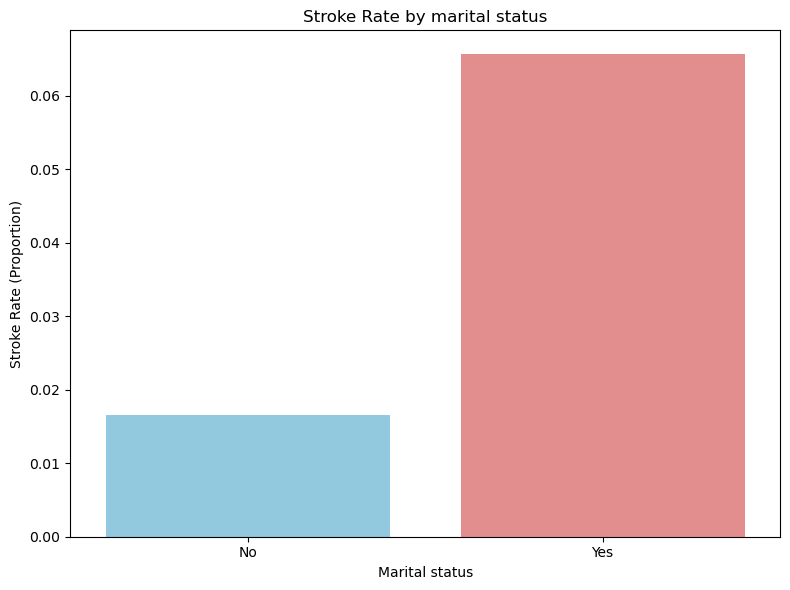

In [26]:
# Calculate stroke rate by ever_married
stroke_rate_ever_married = df.groupby('ever_married')['stroke'].mean().reset_index()

# Create the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x='ever_married', y='stroke', data=stroke_rate_ever_married, palette=['skyblue', 'lightcoral'])
plt.title('Stroke Rate by marital status')
plt.xlabel('Marital status')
plt.ylabel('Stroke Rate (Proportion)')

plt.tight_layout()
plt.savefig('stroke rate marital status')
plt.show()

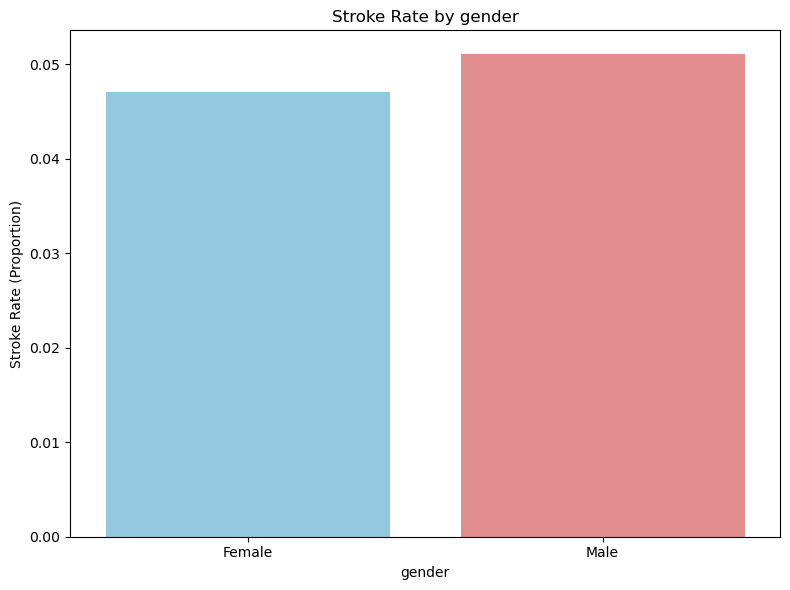

In [27]:
# Calculate stroke rate by gender
stroke_rate_gender = df.groupby('gender')['stroke'].mean().reset_index()

# Create the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x='gender', y='stroke', data=stroke_rate_gender, palette=['skyblue', 'lightcoral'])
plt.title('Stroke Rate by gender')
plt.xlabel('gender')
plt.ylabel('Stroke Rate (Proportion)')

plt.tight_layout()
plt.show()

This stroke rate chart by gender provides a clear, standardized comparison and confirms the pattern observed in the raw counts. Here's the interpretation:

**Stroke Rates by Gender:**
- **Females:** Approximately 4.7% stroke rate
- **Males:** Approximately 5.1% stroke rate

**Key Findings:**

**Gender Difference:**
- Males have about 0.4 percentage points higher stroke rate than females
- This represents roughly an **8.5% higher relative risk** for males compared to females
- The difference is smaller than what my initial calculation suggested from the first chart

**Significance:**
- This chart confirms that **males do have higher stroke rates than females** in this dataset
- However, the gender difference (8.5% relative increase) is notably smaller than the residence difference we saw earlier (~19% relative increase)
- Both rates remain relatively low (under 6%)

**Clinical Context:**
This finding aligns with epidemiological evidence showing males typically have higher stroke risk, though the magnitude here is more modest than often reported in literature. The smaller difference could be due to:
- Age distribution in the dataset (gender differences are more pronounced at younger ages)
- Specific population characteristics
- Sample composition

**Comparative Insight:**
Interestingly, based on these charts, **residence type (urban vs rural) appears to be a stronger predictor of stroke risk than gender** in this particular dataset, which is somewhat unexpected given that gender is typically considered a more significant stroke risk factor.

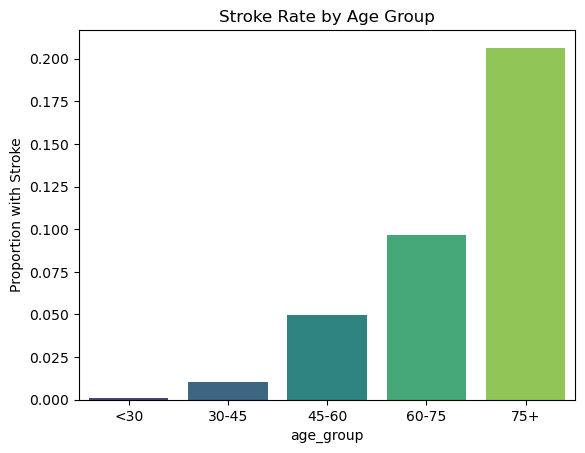

In [28]:
df['age_group'] = pd.cut(df['age'], bins=[0, 30, 45, 60, 75, 100], labels=['<30', '30-45', '45-60', '60-75', '75+'])

stroke_rate = df.groupby('age_group')['stroke'].mean().reset_index()
sns.barplot(x='age_group', y='stroke', data=stroke_rate, palette='viridis')
plt.title('Stroke Rate by Age Group')
plt.ylabel('Proportion with Stroke')
plt.show()

Bar chart showing the **proportion of stroke cases by age group**:

* Stroke risk **increases steadily with age**.
* Individuals **aged 75+** have the **highest stroke rate (\~21%)**.
* Those **under 30** have a **near-zero** stroke rate.
* The increase is gradual between 30 and 75, showing a strong age-related trend.

*Older adults, especially those **over 60**, are at significantly higher risk of stroke. Age is a **strong predictive factor** in the dataset.*

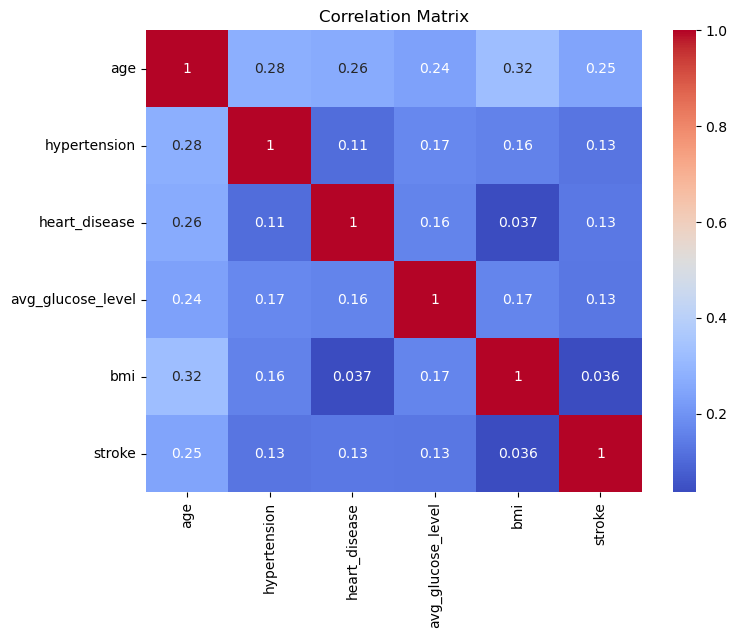

In [29]:
# Correlation heatmap of numerical columns
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [30]:
# Correlation between stroke and other numerical columns
corr_mat = df.corr()
corr_mat['stroke']

age                  0.245239
hypertension         0.127891
heart_disease        0.134905
avg_glucose_level    0.131991
bmi                  0.036075
stroke               1.000000
Name: stroke, dtype: float64

Correlation heatmap showing relationships between numerical features and stroke.


* **Age** has the strongest correlation with stroke (`0.25`), confirming the trend seen in the age group plot.
* **Hypertension, heart disease, avg\_glucose\_level** show correlation of (\~`0.13`), while **BMI** show the **weakest correlation** with stroke.(\~`0.036`)
* There is no multicollinearity as all inter-feature correlations are low (< 0.4).

*Age is the most influential numeric variable in predicting stroke. Other features show weak individual correlations, but may still contribute in combination through modeling.*


In [31]:
# I don't need the age_group column in modelling, so i will drop it.
df.drop('age_group', axis=1, inplace=True)

In [32]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [33]:
# Splitting the dataset into train and test
X = df.drop(columns=['stroke'])
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [34]:
X_train['hypertension'] = X_train['hypertension'].astype('category')
X_train['heart_disease'] = X_train['heart_disease'].astype('category')

In [35]:
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
# numerical_cols = ['age', 'avg_glucose_level', 'bmi']
numerical_cols

['age', 'avg_glucose_level', 'bmi']

In [36]:
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols

['gender',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'residence_type',
 'smoking_status']

In [37]:
# #  Training and evaluating with the unpreprocessed data with Catboost


# cat_features_indices = [X_train.columns.get_loc(col) for col in categorical_cols]

# model = CatBoostClassifier(
#     iterations=1000,
#     learning_rate=0.05,
#     depth=6,
#     eval_metric='AUC',
#     random_seed=42,
#     verbose=100,
#     early_stopping_rounds=50,
#     class_weights=[1, 20],
#     use_best_model=False
# )

# model.fit(X_train, y_train, cat_features=cat_features_indices, eval_set=(X_test, y_test))

In [38]:
#  Confusion Matrix Display function

def plot_confusion_matrix(y_test, y_pred, model_name="Model"):
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm.ravel()

    # Computing percentages
    total_positive = TP + FN  # Actual positive cases
    total_negative = TN + FP  # Actual negative cases

    TP_percent = (TP / total_positive) * 100 if total_positive != 0 else 0
    TN_percent = (TN / total_negative) * 100 if total_negative != 0 else 0
    FP_percent = (FP / total_negative) * 100 if total_negative != 0 else 0
    FN_percent = (FN / total_positive) * 100 if total_positive != 0 else 0

    # Creating annotated confusion matrix with line breaks
    labels = np.array([
        [f"True Negative:\n{TN} of {total_negative}\n({TN_percent:.1f}%)", 
         f"False Positive:\n{FP} of {total_negative}\n({FP_percent:.1f}%)"],

        [f"False Negative:\n{FN} of {total_positive}\n({FN_percent:.1f}%)", 
         f"True Positive:\n{TP} of {total_positive}\n({TP_percent:.1f}%)"]
    ])

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, 
                xticklabels=["Predicted 0", "Predicted 1"],
                yticklabels=["Actual 0", "Actual 1"])

    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()

In [39]:
# catboost_ypred = model.predict(X_test)

# print(classification_report(y_test, catboost_ypred))
# plot_confusion_matrix(y_test, catboost_ypred, 'catboost')

### Preproccessing

In [40]:
# Preprocessing for categorical and numeric columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OrdinalEncoder(), categorical_cols)
    ]
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [41]:
X_train_processed

array([[ 0.20939671, -0.82122128,  0.5492338 , ...,  2.        ,
         1.        ,  2.        ],
       [-0.62984543, -0.48588352, -0.98889978, ...,  2.        ,
         1.        ,  2.        ],
       [-0.3648216 ,  0.30231691, -0.76916641, ...,  2.        ,
         0.        ,  2.        ],
       ...,
       [ 0.78361502, -0.60990029,  0.94992406, ...,  2.        ,
         0.        ,  1.        ],
       [-0.54150415, -0.7128745 , -0.36847615, ...,  2.        ,
         1.        ,  0.        ],
       [ 0.12105544, -1.12051807, -0.13581729, ...,  0.        ,
         1.        ,  2.        ]])

In [42]:
# Handling data imbalance with SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)

# Verifying the class distribution after balancing
from collections import Counter
print("Class distribution before SMOTE:", Counter(y_train))
print("Class distribution after SMOTE:", Counter(y_train_balanced))

Class distribution before SMOTE: Counter({0: 3888, 1: 199})
Class distribution after SMOTE: Counter({0: 3888, 1: 3888})


In [43]:
processed_feature_names = numerical_cols + categorical_cols

X_train = pd.DataFrame(X_train_balanced, columns=processed_feature_names)
X_train.columns

Index(['age', 'avg_glucose_level', 'bmi', 'gender', 'hypertension',
       'heart_disease', 'ever_married', 'work_type', 'residence_type',
       'smoking_status'],
      dtype='object')

### Model Training and Evaluation

In [44]:
lr = LogisticRegression()
lr.fit(X_train_balanced, y_train_balanced)
y_pred = lr.predict(X_test_processed)

              precision    recall  f1-score   support

           0       0.99      0.73      0.84       972
           1       0.13      0.80      0.23        50

    accuracy                           0.73      1022
   macro avg       0.56      0.76      0.53      1022
weighted avg       0.94      0.73      0.81      1022

[[708 264]
 [ 10  40]]


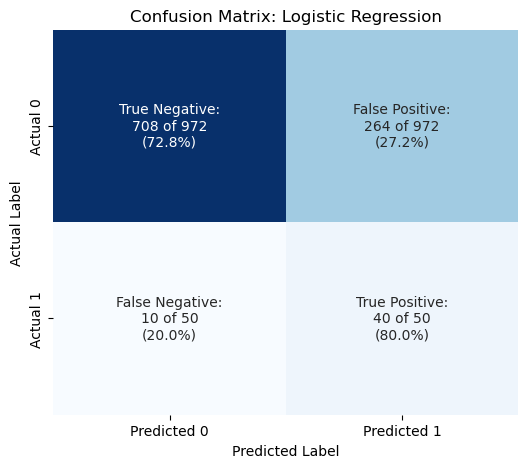

In [45]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, "Logistic Regression")

In [46]:
#  Naive Bayes
gnb=GaussianNB()

gnb.fit(X_train_balanced, y_train_balanced)
gnb_ypred = gnb.predict(X_test_processed)

              precision    recall  f1-score   support

           0       0.98      0.69      0.81       972
           1       0.11      0.74      0.19        50

    accuracy                           0.69      1022
   macro avg       0.54      0.71      0.50      1022
weighted avg       0.94      0.69      0.78      1022



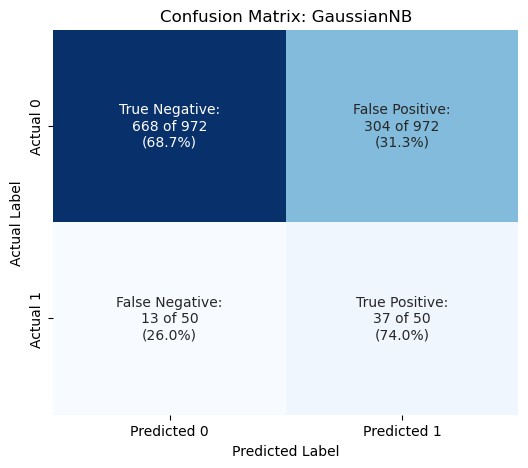

In [47]:
print(classification_report(y_test, gnb_ypred))
plot_confusion_matrix(y_test, gnb_ypred, 'GaussianNB')

### Hyperparameter Tuning and Cross-validation

In [48]:
# For Logistic Regression


param_dist = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced', {0: 1, 1: 10}, {0: 1, 1: 20}]
}



l_reg = LogisticRegression(max_iter=1000, random_state=42)

lr_search = RandomizedSearchCV(
    estimator=l_reg,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

lr_search.fit(X_train_balanced, y_train_balanced)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=1000, random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100,
                                              1000],
                                        'class_weight': [None, 'balanced',
                                                         {0: 1, 1: 10},
                                                         {0: 1, 1: 20}],
                                        'penalty': ['l1', 'l2', 'elasticnet'],
                                        'solver': ['liblinear', 'saga']},
                   random_state=42, scoring='f1', verbose=2)

Best Params: {'solver': 'liblinear', 'penalty': 'l1', 'class_weight': 'balanced', 'C': 0.01}
Best F1 Score (CV): 0.7970832875257846
              precision    recall  f1-score   support

           0       0.99      0.71      0.82       972
           1       0.13      0.84      0.22        50

    accuracy                           0.71      1022
   macro avg       0.56      0.77      0.52      1022
weighted avg       0.95      0.71      0.79      1022

[[686 286]
 [  8  42]]


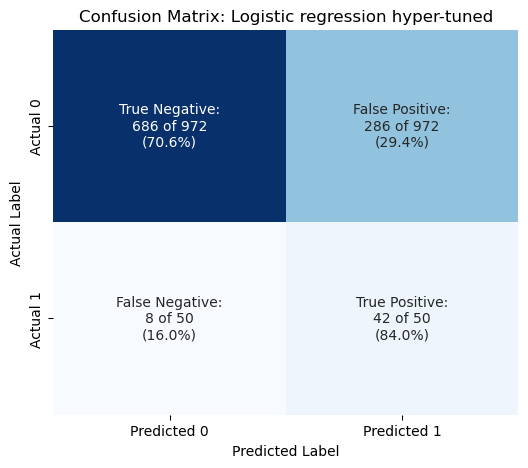

In [49]:
print("Best Params:", lr_search.best_params_)
print("Best F1 Score (CV):", lr_search.best_score_)

# Predict on test data
lr_best_model = lr_search.best_estimator_
lrhp_ypred = lr_best_model.predict(X_test_processed)
print(classification_report(y_test, lrhp_ypred))
print(confusion_matrix(y_test, lrhp_ypred))
plot_confusion_matrix(y_test, lrhp_ypred, 'Logistic regression hyper-tuned')

In [61]:
# Creating a folder to save the best models if it doesn't exist
save_folder = "saved_models"
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# Saving the model using pickle
with open(os.path.join(save_folder, "stroke_prediction.pkl"), "wb") as file:
    pickle.dump(lr_best_model, file)
print("")

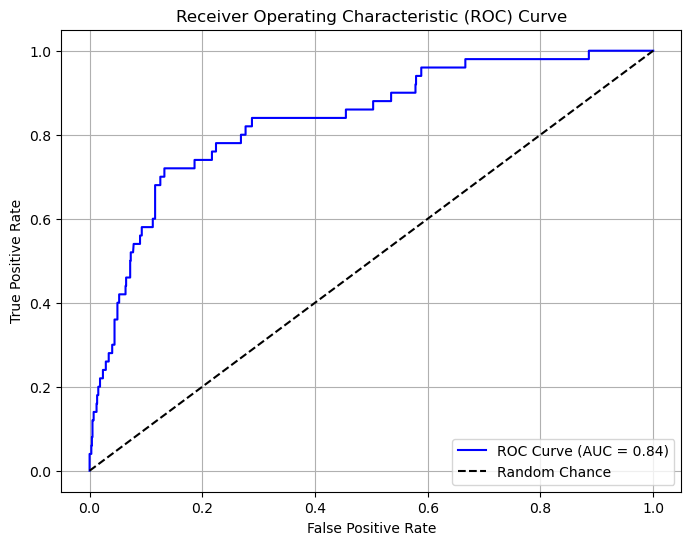

In [58]:
# 1 ROC-Curve

# Predicted probabilities
y_pred_proba = lr_best_model.predict_proba(X_test_processed)[:, 1]

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

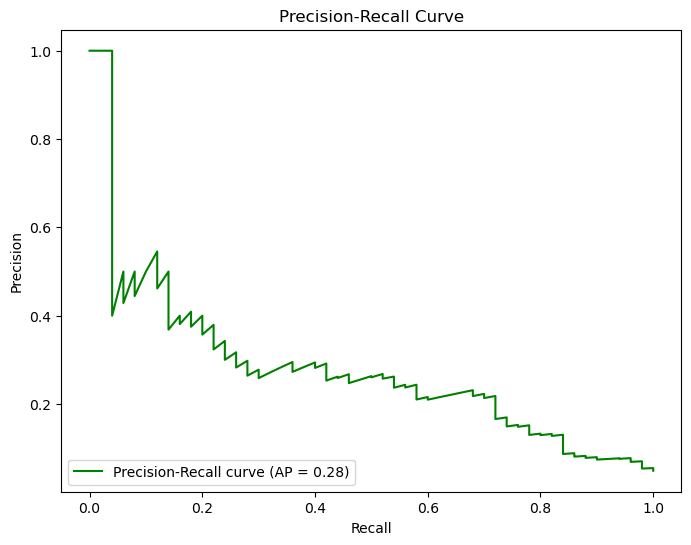

In [59]:
# 2. Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='green', label=f"Precision-Recall curve (AP = {average_precision:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()

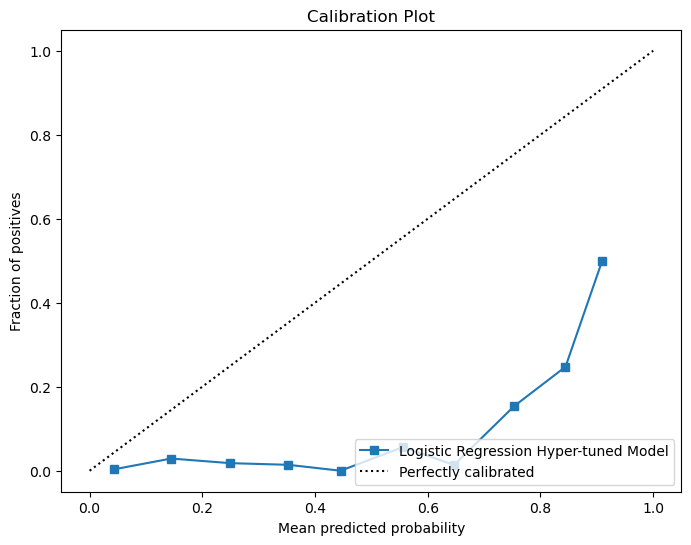

Brier Score: 0.1826


In [52]:
# 3. Calibration Plot and Brier score
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred_proba, n_bins=10)
plt.figure(figsize=(8,6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Logistic Regression Hyper-tuned Model")
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Plot")
plt.legend(loc="lower right")
plt.show()

# Importing brier score
from sklearn.metrics import brier_score_loss

# Computing Brier Score
brier_score = brier_score_loss(y_test, y_pred_proba)
print(f"Brier Score: {brier_score:.4f}")

In [53]:
feature_names=X_train.columns

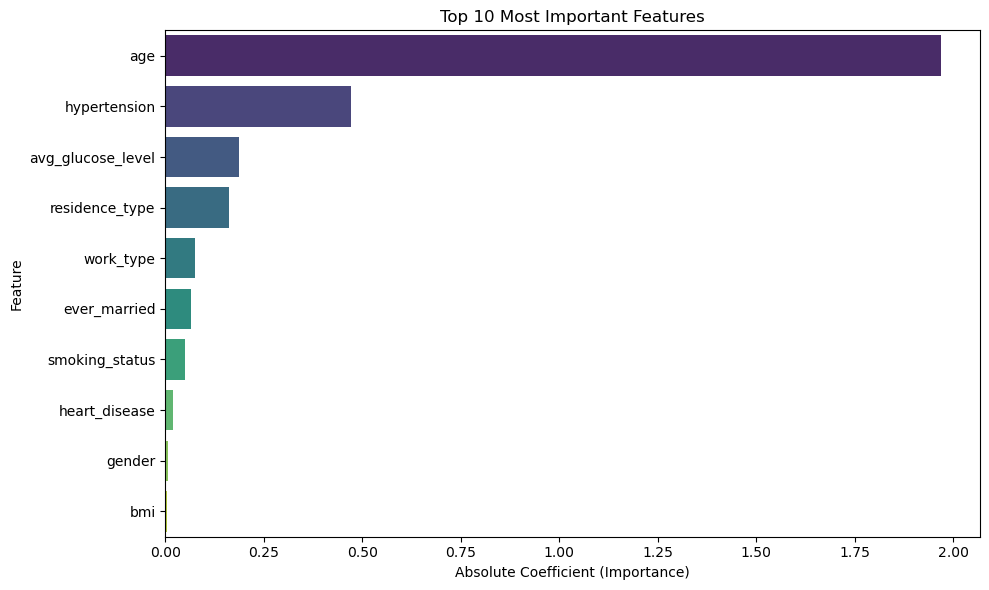

In [54]:
# Feature importance

# coefficients
coefs = lr.coef_[0]

# Pair feature names with their absolute coefficients
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefs,
    'Importance': np.abs(coefs)
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=importance_df,  # Top 10 most important features
    palette='viridis'
)
plt.title('Top 10 Most Important Features')
plt.xlabel('Absolute Coefficient (Importance)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

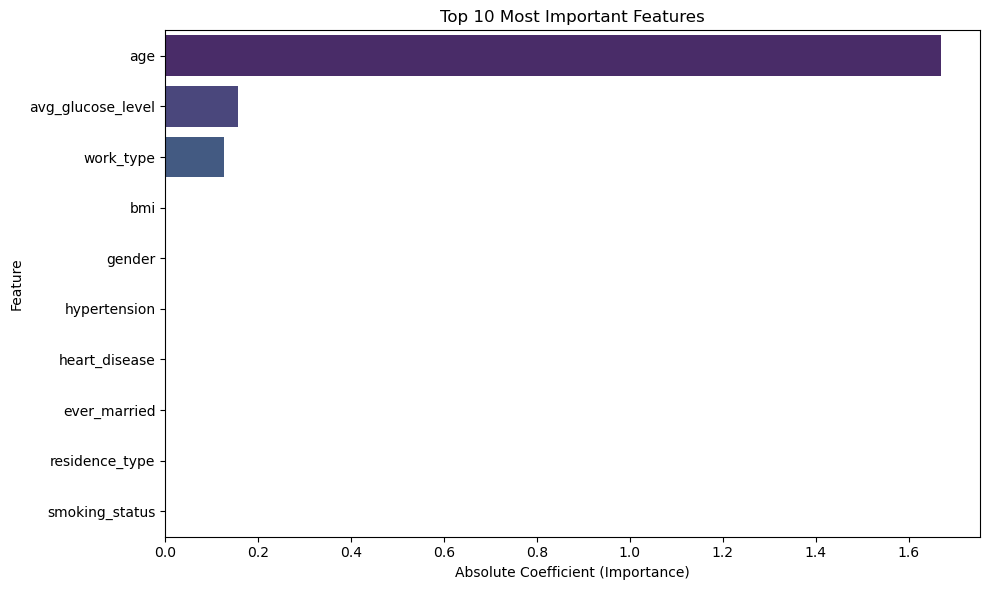

In [55]:
# Feature importance

# coefficients
coefs = lr_best_model.coef_[0]

# Pair feature names with their absolute coefficients
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefs,
    'Importance': np.abs(coefs)
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=importance_df,  # Top 10 most important features
    palette='viridis'
)
plt.title('Top 10 Most Important Features')
plt.xlabel('Absolute Coefficient (Importance)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [78]:
def get_basic_feature_importance(model, feature_names):
    """Get basic feature importance scores"""
    
    # Get feature importance scores
    importance_scores = model.get_feature_importance()
    
    # Create DataFrame
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_scores
    }).sort_values('importance', ascending=False)
    
    return feature_importance_df

feature_names = X_train.columns
importance_df = get_basic_feature_importance(model, feature_names)

NameError: name 'model' is not defined

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x='importance',
    y='feature',
    data=importance_df,  # Top 10 most important features
    palette='viridis'
)
plt.title('Top 10 Most Important Features')
plt.xlabel('Absolute Coefficient (Importance)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
X_train_balanced